In [102]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from statsmodels.api import OLS, add_constant
from segmented import segmented  # For segmented regression; install if needed


## 1. Preperation

Define a custome style for consotent look for all graphs

In [47]:

Colors = ['#4393c3', '#f4a582','#92c5de','#d6604d', '#2166ac', '#d1e5f0']
Colors = Colors


plt.style.use('seaborn-v0_8-white')  # Clean white background, no grey
plt.rcParams.update({
    'figure.figsize': (11, 7),  # Slightly larger, elegant proportions
    'font.family': 'sans-serif',  # Professional typography
    'font.sans-serif': ['Times New Roman', 'Arial', 'Helvetica'],  # Serif + sans-serif options
    'font.size': 12,  # Base font size
    'axes.labelsize': 12,  # Axis labels
    'axes.titlesize': 16,  # Larger, bold titles for impact
    'axes.titleweight': 'bold',  # Emphasize titles
    'axes.grid': True,  # Subtle grid for precision
    'grid.alpha': 0.2,  # Lighter grid for elegance
    'grid.linestyle': '--',  # Dashed grid for sophistication
    'axes.edgecolor': '#333333',  # Darker grey for contrast
    'axes.linewidth': 1.2,  # Slightly thicker lines
    'lines.linewidth': 2.2,  # Enhanced line thickness
    'lines.markeredgewidth': 1.0,  # Crisp marker edges
    'legend.fontsize': 11,  # Slightly larger legend text
    'legend.frameon': True,  # Elegant framed legend
    'legend.framealpha': 0.9,  # Near-opaque frame
    'legend.edgecolor': '#444444',  # Darker legend border
    'xtick.labelsize': 11,  # Enhanced tick readability
    'ytick.labelsize': 11,  # Enhanced tick readability
    'xtick.direction': 'out',  # Outward ticks for clarity
    'ytick.direction': 'out',  # Outward ticks for clarity
    'xtick.major.size': 6,  # Larger tick marks
    'ytick.major.size': 6,  # Larger tick marks
    'savefig.dpi': 600,  # Ultra-high resolution for publication
    'savefig.bbox': 'tight',  # Optimized layout
    'savefig.pad_inches': 0.1,  # Minimal padding
    'patch.edgecolor': '#f7f7f7',  # Light grey for bar strokes
    'patch.linewidth': 0.8  # Subtle edge thickness
})

# Apply Seaborn context with custom palette
sns.set_context("paper", font_scale=1.2)  # Academic paper style, slightly larger
sns.set_palette(Colors)  # Use shuffled custom pastel palette

# Add subtle figure enhancements
plt.rcParams['figure.facecolor'] = 'white'  # Explicitly ensure white background
plt.rcParams['axes.facecolor'] = 'white'  # White plot area
plt.rcParams['legend.loc'] = 'best'  # Optimal legend placement


Read Date

In [5]:
parks_gdf = gpd.read_file('Data/Riyadh_parks_with_all_variables_raw.geojson')
print("Loaded parks_gdf with columns:", parks_gdf.columns) 

Loaded parks_gdf with columns: Index(['osm_id', 'OBJECTID', 'FEATURE_ANAME', 'MUNICIPALITY', 'DISTRICT',
       'WALKING_TRACK', 'GREEN_AREAS', 'LAYERID', 'LAYERANAME', 'Validation',
       ...
       'lst_reduction_tval_LSI', 'lst_reduction_sig_LSI',
       'lst_reduction_coef_building_density',
       'lst_reduction_tval_building_density',
       'lst_reduction_sig_building_density',
       'lst_reduction_coef_building_proximity',
       'lst_reduction_tval_building_proximity',
       'lst_reduction_sig_building_proximity', 'lst_reduction_localR2_proxy',
       'geometry'],
      dtype='object', length=132)


## 2. General Statistics

### Area related exploration

In [6]:
area_m2 = parks_gdf['area_m2']

In [7]:
# Park size distribution
area_m2 = parks_gdf['area_m2']
median_area = np.median(area_m2)
q25, q75 = np.percentile(area_m2, [25, 75])
large_parks = parks_gdf[area_m2 > 15000]  # 15,000 m² = 1.5 hectares
large_park_pct = len(large_parks) / len(parks_gdf) * 100

print(f"Median park area: {median_area:,.0f} m²")
print(f"Interquartile range (IQR): {q25:,.0f} - {q75:,.0f} m²")
print(f"Parks >15,000 m²: {large_park_pct:.1f}%")

Median park area: 5,085 m²
Interquartile range (IQR): 2,927 - 9,996 m²
Parks >15,000 m²: 16.5%


In [8]:
area_stats = {
    'Min': np.min(area_m2),
    'Max': np.max(area_m2),
    'Mean': np.mean(area_m2),
    'Median': np.median(area_m2),
    'Std Dev': np.std(area_m2),
    'IQR': np.percentile(area_m2, 75) - np.percentile(area_m2, 25),
    'Q1 (25%)': np.percentile(area_m2, 25),
    'Q3 (75%)': np.percentile(area_m2, 75),
    '90th %ile': np.percentile(area_m2, 90)
}

#  Size category distribution
size_bins = [0, 1000, 5000, 10000, 15000, 30000, 50000, np.inf]
size_labels = ['<1k', '1k-5k', '5k-10k', '10k-15k', '15k-30k', '30k-50k', '>50k']
parks_gdf['size_category'] = pd.cut(area_m2, bins=size_bins, labels=size_labels)
size_distribution = parks_gdf['size_category'].value_counts(normalize=True).sort_index() * 100

#  Print comprehensive statistics
print("="*50)
print("Park Area Statistics (m²)")
print("="*50)
for stat, value in area_stats.items():
    print(f"{stat:<10}: {value:,.0f} m²")

print("\nSize Category Distribution:")
for size, pct in size_distribution.items():
    print(f"- {size} m²: {pct:.1f}% of parks")


Park Area Statistics (m²)
Min       : 986 m²
Max       : 258,130 m²
Mean      : 14,953 m²
Median    : 5,085 m²
Std Dev   : 34,704 m²
IQR       : 7,069 m²
Q1 (25%)  : 2,927 m²
Q3 (75%)  : 9,996 m²
90th %ile : 30,759 m²

Size Category Distribution:
- <1k m²: 0.5% of parks
- 1k-5k m²: 47.9% of parks
- 5k-10k m²: 26.3% of parks
- 10k-15k m²: 8.8% of parks
- 15k-30k m²: 6.2% of parks
- 30k-50k m²: 3.6% of parks
- >50k m²: 6.7% of parks


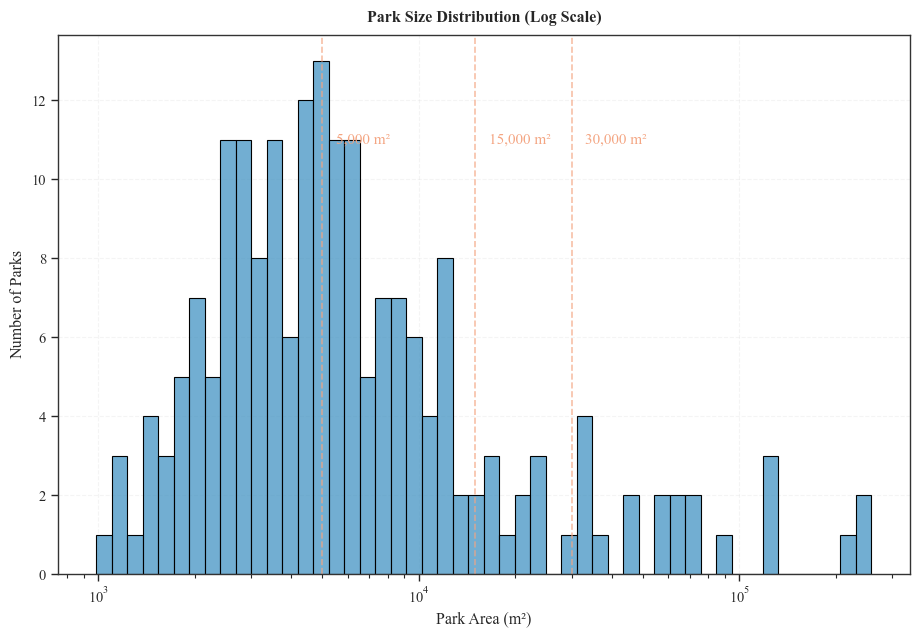

In [9]:
# Detailed histogram with log scale
fig, ax1 = plt.subplots(figsize=(11, 7))  # Use global figsize
sns.histplot(data=parks_gdf, x='area_m2', bins=50, log_scale=True, ax=ax1, color=Colors[0])  # Use first color
ax1.set_title('Park Size Distribution (Log Scale)', pad=10)
ax1.set_xlabel('Park Area (m²)')
ax1.set_ylabel('Number of Parks')
ax1.grid(True, linestyle='--', alpha=0.2)  # Match global grid style

# Add key thresholds
thresholds = [5000, 15000, 30000]
for threshold in thresholds:
    ax1.axvline(threshold, color=Colors[1], linestyle='--', alpha=0.7)  # Use second color for contrast
    ax1.text(threshold * 1.1, ax1.get_ylim()[1] * 0.8, f'{threshold:,.0f} m²', 
             fontsize=11, color=Colors[1], ha='left')

plt.title('Park Size Distribution (Log Scale)', pad=10)  # Redundant if ax1.set_title works
# plt.savefig('park_size_distribution_m2.png', dpi=600, bbox_inches='tight')  # Comment out export
plt.show()

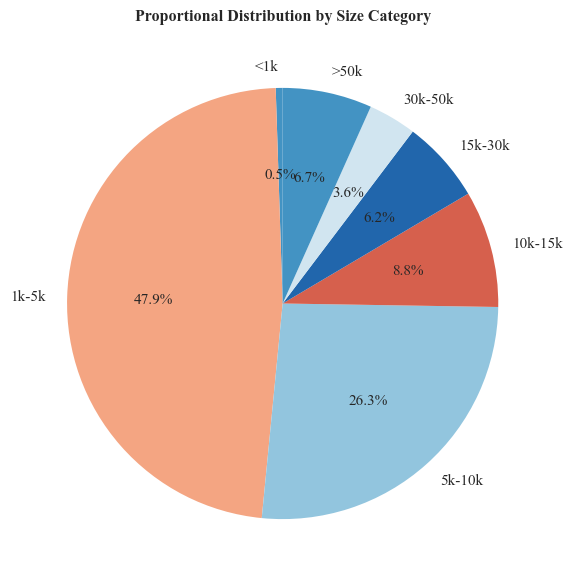

In [10]:

# Size category pie chart
fig, ax2 = plt.subplots(figsize=(11, 7))  # Use global figsize
colors = Colors[:len(size_distribution)]  # Use palette up to number of categories
ax2.pie(size_distribution, labels=size_distribution.index, autopct='%1.1f%%', 
        startangle=90, colors=colors, textprops={'fontsize': 11})
ax2.set_title('Proportional Distribution by Size Category', pad=10)

plt.title('Proportional Distribution by Size Category', pad=10)  # Redundant if ax2.set_title works
# plt.savefig('area_vs_cooling.png', dpi=600)  # Comment out export (note: filename mismatch from original)
plt.show()

In [88]:
parks_gdf['building_density'].describe()

count    194.000000
mean      32.540256
std        7.907630
min        1.359572
25%       28.403743
50%       33.158802
75%       37.660383
max       52.980830
Name: building_density, dtype: float64

### LSI related exploration

In [11]:
# Descriptive Analysis of LSI
lsi_stats = parks_gdf['LSI'].describe()
print("LSI Descriptive Statistics:")
print(lsi_stats)
print(f"Range: {parks_gdf['LSI'].min():.2f} to {parks_gdf['LSI'].max():.2f}")
print(f"Ideal values: 1.00 (circle), 1.13 (square); Observed max (5.76) indicates complex shapes.")


LSI Descriptive Statistics:
count    194.000000
mean       1.218093
std        0.180563
min        1.060000
25%        1.130000
50%        1.170000
75%        1.230000
max        2.900000
Name: LSI, dtype: float64
Range: 1.06 to 2.90
Ideal values: 1.00 (circle), 1.13 (square); Observed max (5.76) indicates complex shapes.


LSI Descriptive Statistics:
count    194.000000
mean       1.218093
std        0.180563
min        1.060000
25%        1.130000
50%        1.170000
75%        1.230000
max        2.900000
Name: LSI, dtype: float64
Range: 1.06 to 2.90
Ideal values: 1.00 (circle), 1.13 (square); Observed max (5.76) indicates complex shapes.


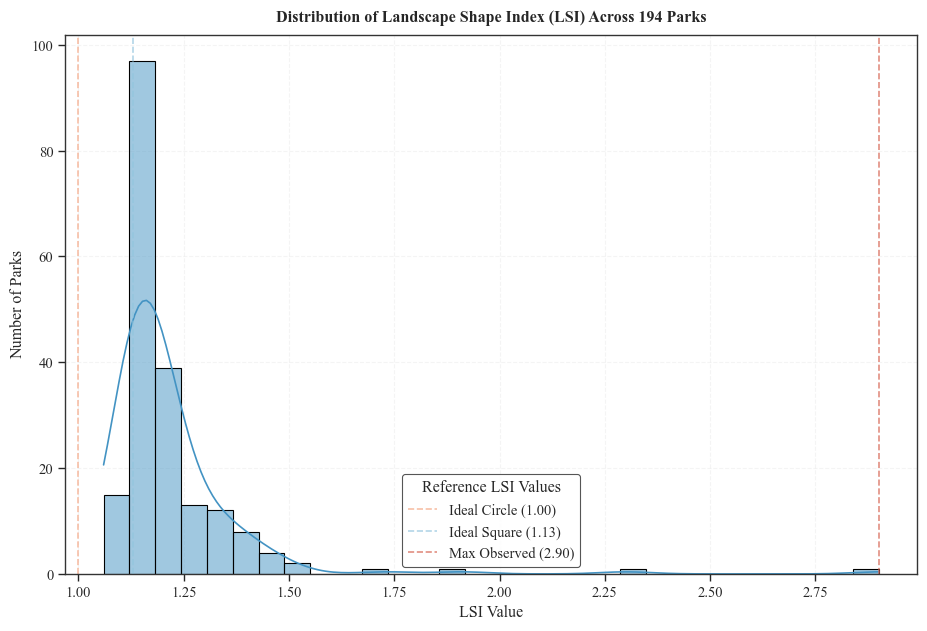

In [12]:
# Descriptive Analysis of LSI
lsi_stats = parks_gdf['LSI'].describe()
print("LSI Descriptive Statistics:")
print(lsi_stats)
print(f"Range: {parks_gdf['LSI'].min():.2f} to {parks_gdf['LSI'].max():.2f}")
print(f"Ideal values: 1.00 (circle), 1.13 (square); Observed max (5.76) indicates complex shapes.")

# Histogram of LSI
fig, ax = plt.subplots(figsize=(11, 7))
sns.histplot(data=parks_gdf, x='LSI', bins=30, color=Colors[0], kde=True, ax=ax)
ax.set_title('Distribution of Landscape Shape Index (LSI) Across 194 Parks', pad=10)
ax.set_xlabel('LSI Value')
ax.set_ylabel('Number of Parks')
ax.grid(True, linestyle='--', alpha=0.2)
# Highlight ideal and observed extreme values
ax.axvline(1.00, color=Colors[1], linestyle='--', alpha=0.7, label='Ideal Circle (1.00)')
ax.axvline(1.13, color=Colors[2], linestyle='--', alpha=0.7, label='Ideal Square (1.13)')
ax.axvline(2.90, color=Colors[3], linestyle='--', alpha=0.7, label='Max Observed (2.90)')
ax.legend(title='Reference LSI Values', loc='best')
# plt.savefig('lsi_distribution.png', dpi=600, bbox_inches='tight')  # Comment out export
plt.show()

### NDVI and PISI related exploration

In [13]:
# Descriptive Statistics
ndvi = parks_gdf['ndvi_mean']
pisi = parks_gdf['pisi_mean']

ndvi_stats = ndvi.describe()
pisi_stats = pisi.describe()
print("NDVI Descriptive Statistics:")
print(ndvi_stats)
print(f"Range: {ndvi.min():.3f} to {ndvi.max():.3f}")
print("\nPISI Descriptive Statistics:")
print(pisi_stats)
print(f"Range: {pisi.min():.3f} to {pisi.max():.3f}")

NDVI Descriptive Statistics:
count    194.000000
mean       0.149629
std        0.035262
min        0.056360
25%        0.126020
50%        0.147426
75%        0.172987
max        0.235770
Name: ndvi_mean, dtype: float64
Range: 0.056 to 0.236

PISI Descriptive Statistics:
count    194.000000
mean      -0.173575
std        0.069084
min       -0.376677
25%       -0.220448
50%       -0.177248
75%       -0.127368
max        0.045596
Name: pisi_mean, dtype: float64
Range: -0.377 to 0.046


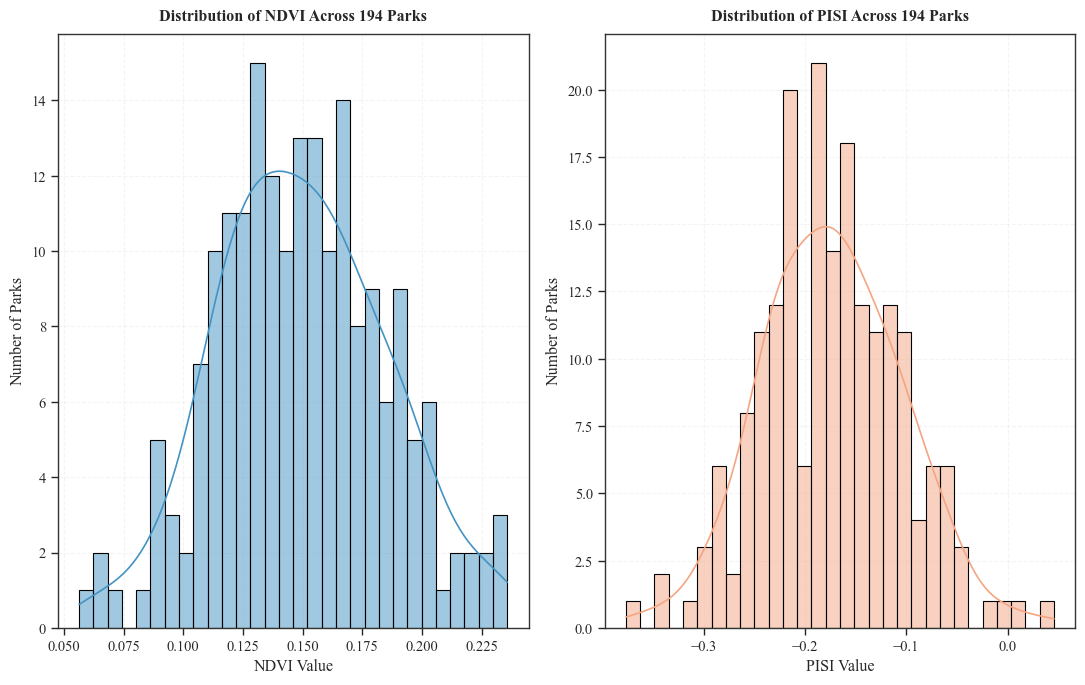

In [14]:
# Histograms
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 7))
sns.histplot(data=parks_gdf, x='ndvi_mean', bins=30, color=Colors[0], kde=True, ax=ax1)
ax1.set_title('Distribution of NDVI Across 194 Parks', pad=10)
ax1.set_xlabel('NDVI Value')
ax1.set_ylabel('Number of Parks')
ax1.grid(True, linestyle='--', alpha=0.2)

sns.histplot(data=parks_gdf, x='pisi_mean', bins=30, color=Colors[1], kde=True, ax=ax2)
ax2.set_title('Distribution of PISI Across 194 Parks', pad=10)
ax2.set_xlabel('PISI Value')
ax2.set_ylabel('Number of Parks')
ax2.grid(True, linestyle='--', alpha=0.2)

plt.tight_layout()
# plt.savefig('ndvi_pisi_distributions.png', dpi=600, bbox_inches='tight')  # Comment out export
plt.show()

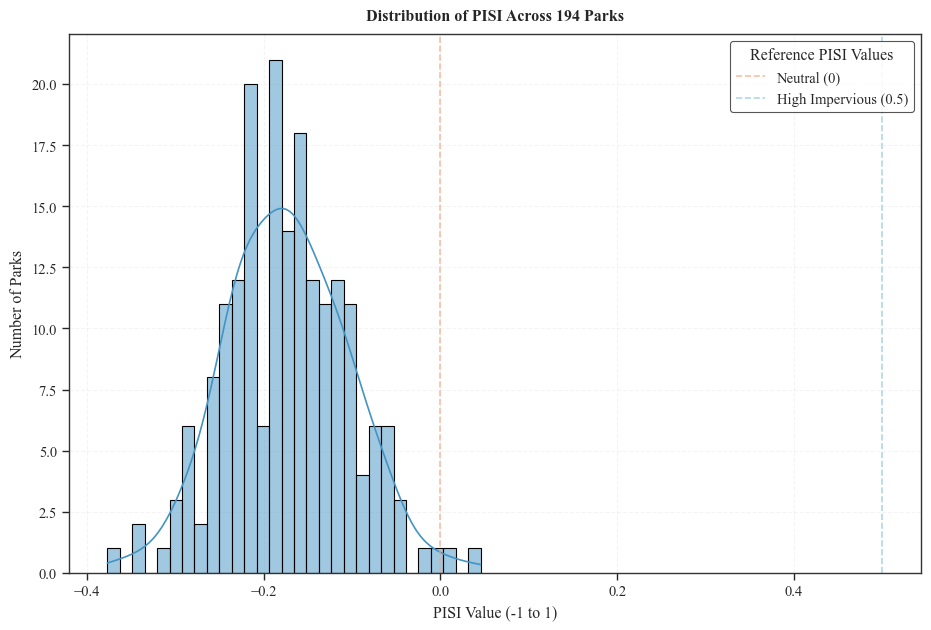

In [15]:
# Histogram of PISI
fig, ax = plt.subplots(figsize=(11, 7))
sns.histplot(data=parks_gdf, x='pisi_mean', bins=30, color=Colors[0], kde=True, ax=ax)
ax.set_title('Distribution of PISI Across 194 Parks', pad=10)
ax.set_xlabel('PISI Value (-1 to 1)')
ax.set_ylabel('Number of Parks')
ax.grid(True, linestyle='--', alpha=0.2)
# Highlight key thresholds
ax.axvline(0, color=Colors[1], linestyle='--', alpha=0.7, label='Neutral (0)')
ax.axvline(0.5, color=Colors[2], linestyle='--', alpha=0.7, label='High Impervious (0.5)')
ax.legend(title='Reference PISI Values', loc='best')
# plt.savefig('pisi_distribution.png', dpi=600, bbox_inches='tight')  # Comment out export
plt.show()

In [16]:
# 2. Vegetation characteristics
ndvi = parks_gdf['ndvi_mean']
pisi = parks_gdf['pisi_mean']
high_ndvi_pct = (ndvi > 0.2).sum() / len(ndvi) * 100

print(f"\nNDVI (greenness): {np.mean(ndvi):.2f} ± {np.std(ndvi):.2f}")
print(f"Impervious surfaces (PISI): {np.mean(pisi):.2f} ± {np.std(pisi):.2f}")
print(f"Parks with NDVI >0.2: {high_ndvi_pct:.1f}%")


NDVI (greenness): 0.15 ± 0.04
Impervious surfaces (PISI): -0.17 ± 0.07
Parks with NDVI >0.2: 8.2%


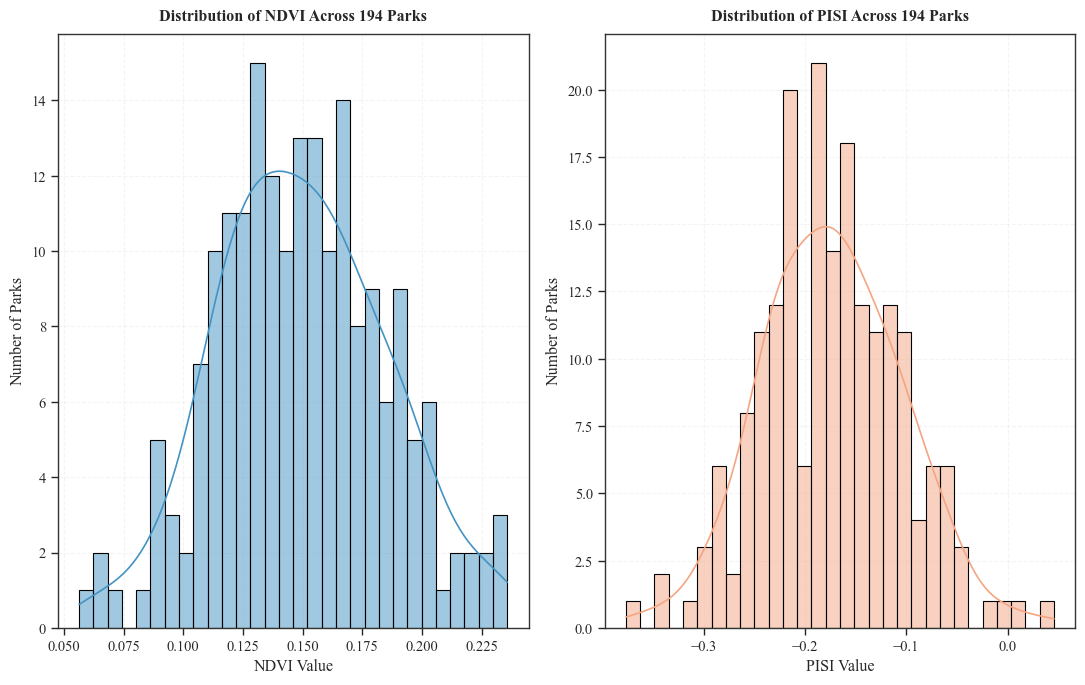

In [17]:
# Histograms
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 7))
sns.histplot(data=parks_gdf, x='ndvi_mean', bins=30, color=Colors[0], kde=True, ax=ax1)
ax1.set_title('Distribution of NDVI Across 194 Parks', pad=10)
ax1.set_xlabel('NDVI Value')
ax1.set_ylabel('Number of Parks')
ax1.grid(True, linestyle='--', alpha=0.2)

sns.histplot(data=parks_gdf, x='pisi_mean', bins=30, color=Colors[1], kde=True, ax=ax2)
ax2.set_title('Distribution of PISI Across 194 Parks', pad=10)
ax2.set_xlabel('PISI Value')
ax2.set_ylabel('Number of Parks')
ax2.grid(True, linestyle='--', alpha=0.2)

plt.tight_layout()
# plt.savefig('ndvi_pisi_distributions.png', dpi=600, bbox_inches='tight')  # Comment out export
plt.show()

### Built environment related exploration

In [18]:
# 3. Built environment metrics
bldg_density = parks_gdf['building_density']
bldg_proximity = parks_gdf['building_proximity']

print(f"\nBuilding density: {np.mean(bldg_density):.1f} ± {np.std(bldg_density):.1f} buildings/ha")
print(f"Building proximity: {np.median(bldg_proximity):.1f} m (IQR: "
      f"{np.percentile(bldg_proximity, 25):.1f}-{np.percentile(bldg_proximity, 75):.1f} m)")



Building density: 32.5 ± 7.9 buildings/ha
Building proximity: 15.8 m (IQR: 11.4-20.7 m)


In [19]:
# Descriptive Statistics
bldg_density_stats = bldg_density.describe()
bldg_proximity_stats = bldg_proximity.describe()
print("Building Density Descriptive Statistics (%):")
print(bldg_density_stats)
print(f"Range: {bldg_density.min():.2f}% to {bldg_density.max():.2f}%")
print("\nBuilding Proximity Descriptive Statistics (m):")
print(bldg_proximity_stats)
print(f"Range: {bldg_proximity.min():.2f}m to {bldg_proximity.max():.2f}m")

Building Density Descriptive Statistics (%):
count    194.000000
mean      32.540256
std        7.907630
min        1.359572
25%       28.403743
50%       33.158802
75%       37.660383
max       52.980830
Name: building_density, dtype: float64
Range: 1.36% to 52.98%

Building Proximity Descriptive Statistics (m):
count    194.000000
mean      17.870162
std       11.958802
min        1.620812
25%       11.352582
50%       15.768115
75%       20.725466
max       96.376621
Name: building_proximity, dtype: float64
Range: 1.62m to 96.38m


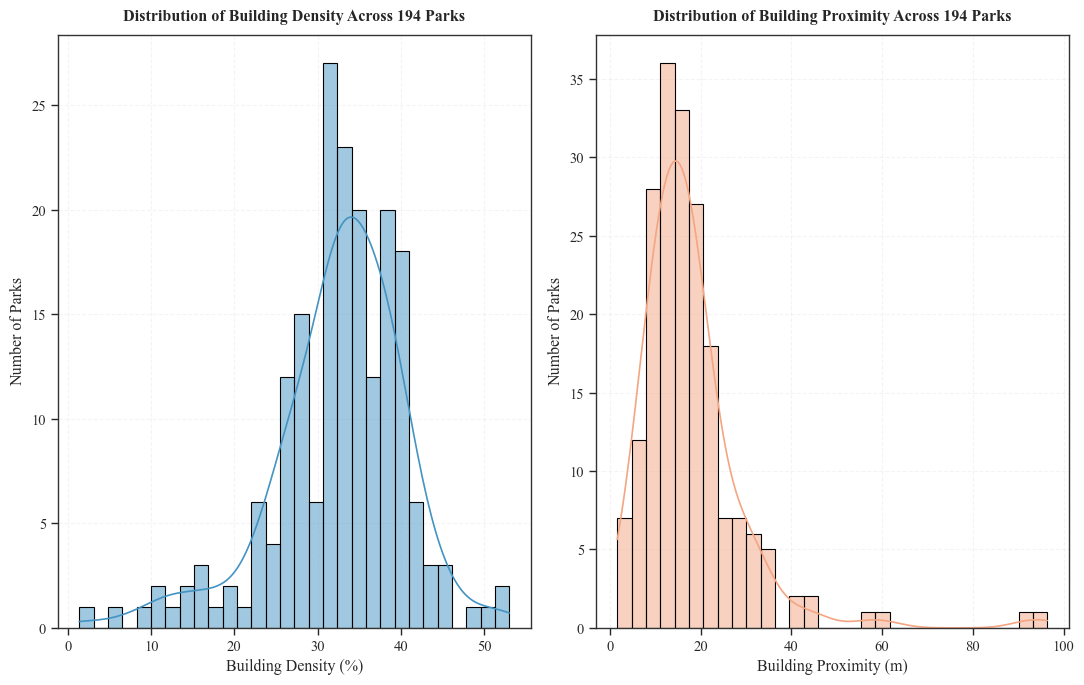

In [20]:
# Histograms
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 7))
sns.histplot(data=parks_gdf, x='building_density', bins=30, color=Colors[0], kde=True, ax=ax1)
ax1.set_title('Distribution of Building Density Across 194 Parks', pad=10)
ax1.set_xlabel('Building Density (%)')
ax1.set_ylabel('Number of Parks')
ax1.grid(True, linestyle='--', alpha=0.2)

sns.histplot(data=parks_gdf, x='building_proximity', bins=30, color=Colors[1], kde=True, ax=ax2)
ax2.set_title('Distribution of Building Proximity Across 194 Parks', pad=10)
ax2.set_xlabel('Building Proximity (m)')
ax2.set_ylabel('Number of Parks')
ax2.grid(True, linestyle='--', alpha=0.2)

plt.tight_layout()
# plt.savefig('bldg_density_proximity_distributions.png', dpi=600, bbox_inches='tight')  # Comment out export
plt.show()

## 3. Cooling Reduction

In [21]:
# Descriptive Statistics of Cooling Metrics
cooling_metrics = ['PCI', 'PCA', 'PCE', 'lst_reduction']
units = ['°C', 'm²', '', '°C']
stats_df = pd.DataFrame(index=['Mean', 'Min', 'Max', 'SD'], columns=cooling_metrics)
for metric in cooling_metrics:
    stats_df.loc['Mean', metric] = parks_gdf[metric].mean()
    stats_df.loc['Min', metric] = parks_gdf[metric].min()
    stats_df.loc['Max', metric] = parks_gdf[metric].max()
    stats_df.loc['SD', metric] = parks_gdf[metric].std()
print("Cooling Metrics Summary (Raw Units):\n", stats_df.round(2))

Cooling Metrics Summary (Raw Units):
            PCI            PCA        PCE lst_reduction
Mean   0.51261   48527.212756  10.317871      0.463619
Min  -1.956827    8941.278478   0.384186     -1.199007
Max   6.950153  133933.704782  41.708454      6.679984
SD    0.970277   18877.056199   8.345576      0.808022


In [22]:
# Threshold Analysis (Quartile Binning) - Updated to suppress FutureWarning
for metric in cooling_metrics:
    parks_gdf[f'{metric}_quartile'] = pd.qcut(parks_gdf[metric], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
    print(f"\n{metric} Threshold Summary (Raw Units):")
    grouped = parks_gdf.groupby(f'{metric}_quartile', observed=False)[metric].agg(['mean', 'std']).round(2)
    ci_low, ci_high = stats.t.interval(0.95, len(parks_gdf)-1, loc=grouped['mean'], scale=grouped['std']/np.sqrt(len(parks_gdf)))
    print(pd.DataFrame({'Mean': grouped['mean'], '95% CI Low': ci_low, '95% CI High': ci_high}))


PCI Threshold Summary (Raw Units):
              Mean  95% CI Low  95% CI High
PCI_quartile                               
Q1           -0.51   -0.559562    -0.460438
Q2            0.18    0.160175     0.199825
Q3            0.66    0.638759     0.681241
Q4            1.72    1.584059     1.855941

PCA Threshold Summary (Raw Units):
                  Mean    95% CI Low   95% CI High
PCA_quartile                                      
Q1            25362.43  24122.423335  26602.436665
Q2            44421.91  43980.256245  44863.563755
Q3            53759.22  53429.760014  54088.679986
Q4            70588.28  68338.376474  72838.183526

PCE Threshold Summary (Raw Units):
               Mean  95% CI Low  95% CI High
PCE_quartile                                
Q1             2.26    2.105650     2.414350
Q2             6.00    5.844234     6.155766
Q3            10.65   10.412103    10.887897
Q4            22.28   21.341158    23.218842

lst_reduction Threshold Summary (Raw Units):
      

### Internal (lst_reduction)

In [23]:
# Descriptive Statistics and Quartiles for lst_reduction
lst_stats = parks_gdf['lst_reduction'].describe()
q3 = parks_gdf['lst_reduction'].quantile(0.75)
top_quartile = parks_gdf[parks_gdf['lst_reduction'] >= q3]['lst_reduction']
top_quartile_mean = top_quartile.mean()

print("LST Reduction Descriptive Statistics:")
print(lst_stats.round(2))
print(f"\nTop Quartile Threshold (Q3): {q3:.2f}°C")
print(f"Top Quartile Mean: {top_quartile_mean:.2f}°C")


LST Reduction Descriptive Statistics:
count    194.00
mean       0.46
std        0.81
min       -1.20
25%       -0.02
50%        0.38
75%        0.78
max        6.68
Name: lst_reduction, dtype: float64

Top Quartile Threshold (Q3): 0.78°C
Top Quartile Mean: 1.41°C


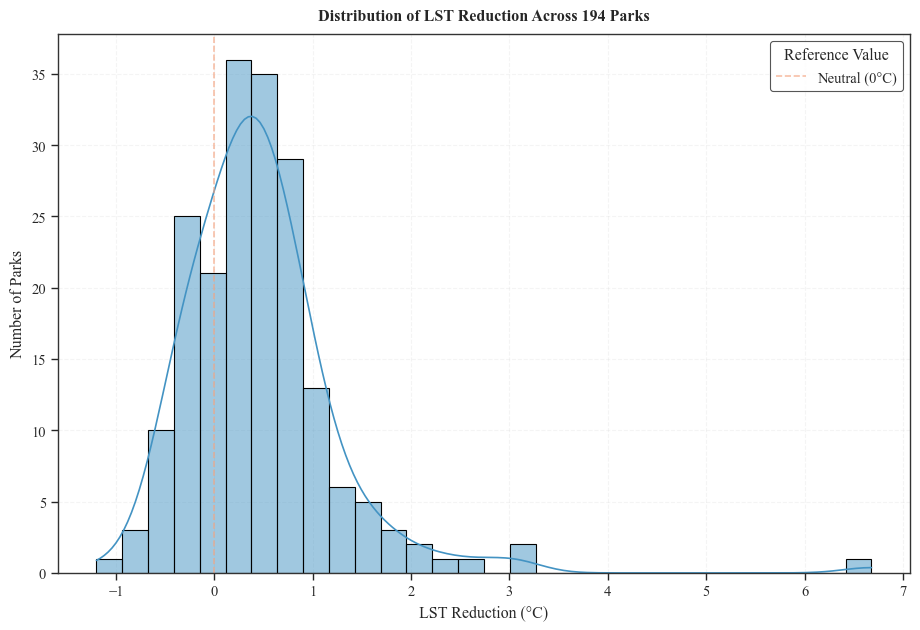

In [24]:
# Histogram of lst_reduction
fig, ax = plt.subplots(figsize=(11, 7))
sns.histplot(data=parks_gdf, x='lst_reduction', bins=30, color=Colors[0], kde=True, ax=ax)
ax.set_title('Distribution of LST Reduction Across 194 Parks', pad=10)
ax.set_xlabel('LST Reduction (°C)')
ax.set_ylabel('Number of Parks')
ax.grid(True, linestyle='--', alpha=0.2)
ax.axvline(0, color=Colors[1], linestyle='--', alpha=0.7, label='Neutral (0°C)')
ax.legend(title='Reference Value', loc='best')
# plt.savefig('lst_reduction_distribution.png', dpi=600, bbox_inches='tight')  # Comment out export
plt.show()

In [25]:
# Inverse Effect Parks (lst_reduction > 0)
inverse_parks = parks_gdf[parks_gdf['lst_reduction'] < 0]
inverse_count = len(inverse_parks)
inverse_pct = (inverse_count / len(parks_gdf)) * 100
inverse_mean = inverse_parks['lst_reduction'].mean()
inverse_max = inverse_parks['lst_reduction'].max()
inverse_min = inverse_parks['lst_reduction'].min()

print(f"Inverse Parks (Heating Effect) Count: {inverse_count} ({inverse_pct:.1f}%)")
print(f"Inverse Mean LST Increase: {inverse_mean:.2f}°C")
print(f"Inverse Range: {inverse_min:.2f}°C to {inverse_max:.2f}°C")

# Summary of Key Factors in Inverse Parks
key_factors = ['ndvi_mean', 'pisi_mean', 'LSI', 'building_density', 'building_proximity', 'area_m2']
inverse_factors = inverse_parks[key_factors].describe().round(2)
print("\nKey Factors in Inverse Parks Summary:\n", inverse_factors)


Inverse Parks (Heating Effect) Count: 51 (26.3%)
Inverse Mean LST Increase: -0.30°C
Inverse Range: -1.20°C to -0.00°C

Key Factors in Inverse Parks Summary:
        ndvi_mean  pisi_mean    LSI  building_density  building_proximity  \
count      51.00      51.00  51.00             51.00               51.00   
mean        0.13      -0.15   1.21             31.71               18.80   
std         0.03       0.06   0.09              8.17                8.32   
min         0.07      -0.25   1.11              8.93                4.27   
25%         0.11      -0.19   1.14             27.84               12.22   
50%         0.13      -0.16   1.20             32.79               18.39   
75%         0.15      -0.11   1.23             37.48               22.73   
max         0.18       0.05   1.51             44.92               45.75   

        area_m2  
count     51.00  
mean    8184.06  
std    12809.06  
min      986.45  
25%     2860.34  
50%     4686.36  
75%     6754.80  
max    64641.

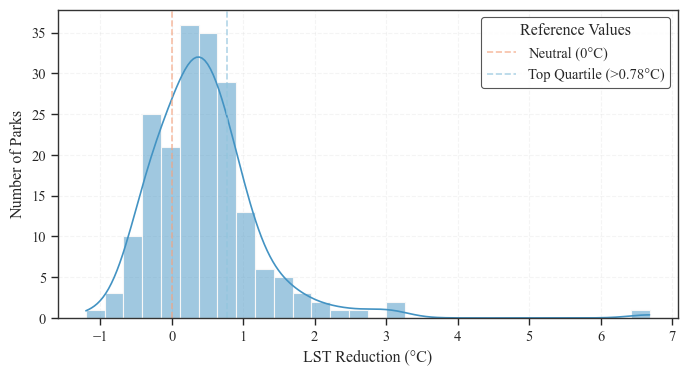

In [58]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.histplot(data=parks_gdf, x='lst_reduction', bins=30, color=Colors[0], kde=True, ax=ax)
# ax.set_title('Distribution of LST Reduction Across 194 Parks (°C)', pad=10)
ax.set_xlabel('LST Reduction (°C)')
ax.set_ylabel('Number of Parks')
ax.grid(True, linestyle='--', alpha=0.2)
ax.axvline(0, color=Colors[1], linestyle='--', alpha=0.7, label='Neutral (0°C)')
ax.axvline(0.78, color=Colors[2], linestyle='--', alpha=0.7, label='Top Quartile (>0.78°C)')
ax.legend(title='Reference Values', loc='best')
plt.savefig('lst_reduction_distribution.png', dpi=600, bbox_inches='tight')  # Comment out export
plt.show()

In [27]:
for metric in ['lst_reduction', 'PCI']:
    parks_gdf[f'{metric}_quartile'] = pd.qcut(parks_gdf[metric], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
    grouped = parks_gdf.groupby(f'{metric}_quartile', observed=False)[metric].agg(['mean', 'std']).round(2)
    ci_low, ci_high = stats.t.interval(0.95, len(parks_gdf)-1, loc=grouped['mean'], scale=grouped['std']/np.sqrt(len(parks_gdf)))
    print(f"{metric} Threshold Summary:\n", pd.DataFrame({'Mean': grouped['mean'], '95% CI Low': ci_low, '95% CI High': ci_high}))

lst_reduction Threshold Summary:
                         Mean  95% CI Low  95% CI High
lst_reduction_quartile                               
Q1                     -0.32   -0.352569    -0.287431
Q2                      0.21    0.193007     0.226993
Q3                      0.55    0.533007     0.566993
Q4                      1.41    1.272643     1.547357
PCI Threshold Summary:
               Mean  95% CI Low  95% CI High
PCI_quartile                               
Q1           -0.51   -0.559562    -0.460438
Q2            0.18    0.160175     0.199825
Q3            0.66    0.638759     0.681241
Q4            1.72    1.584059     1.855941


### Extternal

In [28]:
# 4. Cooling performance metrics
lst_reduction = parks_gdf['lst_reduction']
pci = parks_gdf['PCI']
pce = parks_gdf['PCE']

top_25_threshold = np.percentile(lst_reduction, 75)
pce_range = np.max(pce) - np.min(pce)

print(f"\nLST reduction: {np.mean(lst_reduction):.2f} ± {np.std(lst_reduction):.2f}°C")
print(f"Top 25% cooling performance: >{top_25_threshold:.1f}°C")
print(f"Cooling efficiency (PCE) range: {np.min(pce):.1f} - {np.max(pce):.1f}°C/m² "
      f"({pce_range/np.min(pce):.0f}x variation)")


LST reduction: 0.46 ± 0.81°C
Top 25% cooling performance: >0.8°C
Cooling efficiency (PCE) range: 0.4 - 41.7°C/m² (108x variation)


In [30]:

# Statistical summary
cooling_metrics = parks_gdf[['PCD', 'PCI', 'PCA', 'PCE']].describe()
print("\nStatistical Summary of Cooling Metrics")
print(cooling_metrics.round(2))

# Categorize cooling vs. heating parks
heating_parks = parks_gdf[parks_gdf['PCI'] < 0].shape[0]
cooling_parks = parks_gdf[parks_gdf['PCI'] >= 0].shape[0]
total_parks = len(parks_gdf)
print(f"\nCooling Parks (PCI < 0): {cooling_parks} ({cooling_parks/total_parks*100:.1f}%)")
print(f"Heating Parks (PCI >= 0): {heating_parks} ({heating_parks/total_parks*100:.1f}%)")



Statistical Summary of Cooling Metrics
          PCD     PCI        PCA     PCE
count  194.00  194.00     194.00  194.00
mean   205.69    0.51   48527.21   10.32
std     71.42    0.97   18877.06    8.35
min     30.00   -1.96    8941.28    0.38
25%    161.70   -0.07   38632.39    4.15
50%    222.21    0.41   49207.35    7.91
75%    257.13    0.98   58584.01   14.04
max    300.00    6.95  133933.70   41.71

Cooling Parks (PCI < 0): 137 (70.6%)
Heating Parks (PCI >= 0): 57 (29.4%)


#### Investigation of Inverse Effects

In [31]:
parks_gdf_cooling = parks_gdf[parks_gdf['PCI'] >= 0]

In [32]:
# Statistical summary for cooling parks 
cooling_metrics = parks_gdf_cooling[['PCD', 'PCI', 'PCA', 'PCE']].describe()
print("\nStatistical Summary of Cooling Metrics")
print(cooling_metrics.round(2))


Statistical Summary of Cooling Metrics
          PCD     PCI        PCA     PCE
count  137.00  137.00     137.00  137.00
mean   212.27    0.91   50721.79    9.84
std     63.64    0.86   18376.19    7.84
min     30.00    0.01   10274.12    0.38
25%    173.30    0.38   40858.14    3.97
50%    222.40    0.71   50960.83    7.59
75%    256.54    1.21   59242.30   13.99
max    300.00    6.95  133933.70   39.87


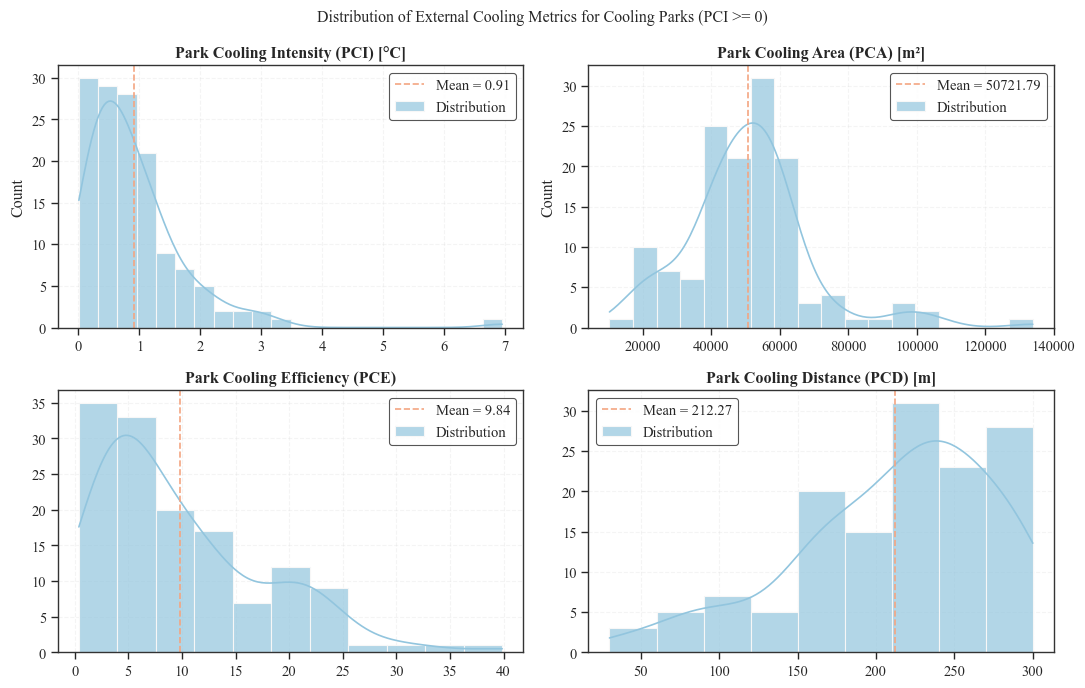

In [60]:
# Create a figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=plt.rcParams['figure.figsize'], sharey=False)
fig.suptitle('Distribution of External Cooling Metrics for Cooling Parks (PCI >= 0)', fontsize=plt.rcParams['axes.titlesize'])

# List of metrics and their labels
metrics = ['PCI', 'PCA', 'PCE', 'PCD']
titles = ['Park Cooling Intensity (PCI) [°C]', 'Park Cooling Area (PCA) [m²]', 
          'Park Cooling Efficiency (PCE)', 'Park Cooling Distance (PCD) [m]']

# Plot each metric with the same color and light grey edges
for ax, metric, title in zip(axes.flatten(), metrics, titles):
    sns.histplot(data=parks_gdf_cooling, x=metric, ax=ax, kde=True, color=Colors[2], 
                 label='Distribution', alpha=0.7, edgecolor=plt.rcParams['patch.edgecolor'], 
                 linewidth=plt.rcParams['patch.linewidth'])
    mean_value = parks_gdf_cooling[metric].mean()
    ax.axvline(mean_value, color=Colors[1], linestyle='--', linewidth=plt.rcParams['lines.linewidth'], 
               label=f'Mean = {mean_value:.2f}')
    ax.set_title(title, fontweight=plt.rcParams['axes.titleweight'])
    ax.set_xlabel('')
    ax.set_ylabel('Count' if ax in axes[0] else '')
    ax.legend(loc=plt.rcParams['legend.loc'], frameon=plt.rcParams['legend.frameon'], 
              framealpha=plt.rcParams['legend.framealpha'], edgecolor=plt.rcParams['legend.edgecolor'])

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.savefig('cooling_metrics_distribution.png', dpi=plt.rcParams['savefig.dpi'], 
            bbox_inches=plt.rcParams['savefig.bbox'], pad_inches=plt.rcParams['savefig.pad_inches'])
plt.show()

#### Investigating PCE

In [35]:
high_pce_negative_pci = parks_gdf[(parks_gdf['PCE'] > 18.65) & (parks_gdf['PCI'] < 0)]
print(high_pce_negative_pci[['PCI', 'PCE', 'PCA', 'PCD', 'ndvi_mean', 'pisi_mean', 'LSI', 'building_density', 'building_proximity', 'area_m2']].describe())

             PCI        PCE           PCA         PCD  ndvi_mean  pisi_mean  \
count  11.000000  11.000000     11.000000   11.000000  11.000000  11.000000   
mean   -0.494418  27.290202  50929.565541  256.029146   0.134341  -0.125548   
std     0.292665   8.254895   7941.606241   35.906386   0.029486   0.065646   
min    -0.969679  18.732431  36353.653436  190.859835   0.081085  -0.239955   
25%    -0.696019  21.239228  47093.002335  236.306865   0.115270  -0.167876   
50%    -0.473372  24.582292  52856.329659  255.193920   0.137110  -0.126034   
75%    -0.338733  31.791795  56920.411743  286.892719   0.150387  -0.089245   
max    -0.036704  41.708454  60378.702798  300.000000   0.177096  -0.010649   

             LSI  building_density  building_proximity      area_m2  
count  11.000000         11.000000           11.000000    11.000000  
mean    1.179091         27.553570           20.522970  2008.417273  
std     0.083601         10.512260           11.532753   584.997722  
min     

In [37]:
outliers_pce = parks_gdf_cooling[parks_gdf_cooling['PCE'] > 29.02]
print(outliers_pce[['PCE', 'PCA', 'PCD', 'ndvi_mean', 'pisi_mean', 'LSI', 'building_density', 'building_proximity', 'area_m2']].describe())
print(f"Number of outliers: {outliers_pce.shape[0]}")

             PCE           PCA         PCD  ndvi_mean  pisi_mean       LSI  \
count   3.000000      3.000000    3.000000   3.000000   3.000000  3.000000   
mean   34.266931  52848.043441  262.052508   0.110263  -0.118839  1.176667   
std     5.080267   5710.621871   28.091791   0.037662   0.115122  0.041633   
min    29.971089  46873.657770  236.625844   0.066893  -0.210575  1.130000   
25%    31.463200  50146.014252  246.974284   0.098034  -0.183430  1.160000   
50%    32.955312  53418.370735  257.322725   0.129175  -0.156285  1.190000   
75%    36.414852  55835.236277  274.765840   0.131949  -0.072970  1.200000   
max    39.874393  58252.101818  292.208956   0.134722   0.010344  1.210000   

       building_density  building_proximity      area_m2  
count          3.000000            3.000000     3.000000  
mean          37.523015           13.209778  1555.186667  
std            5.886191            3.944797   197.653981  
min           33.166454            9.895440  1422.340000  
25

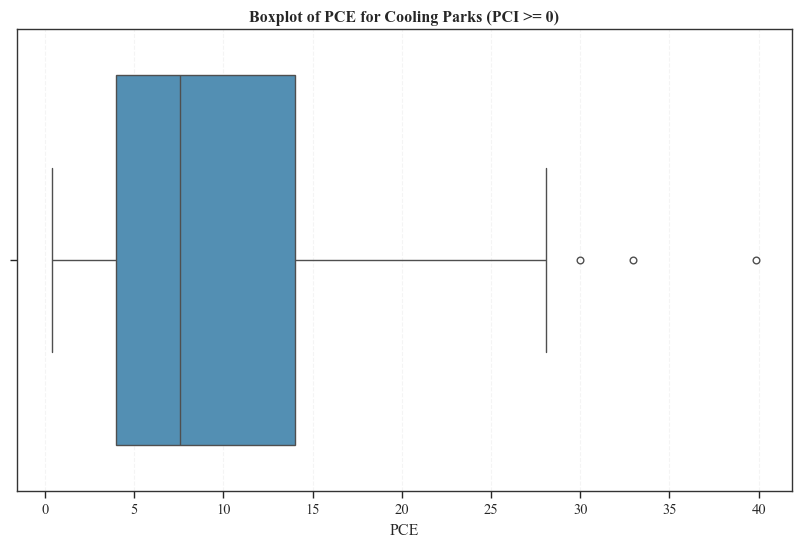

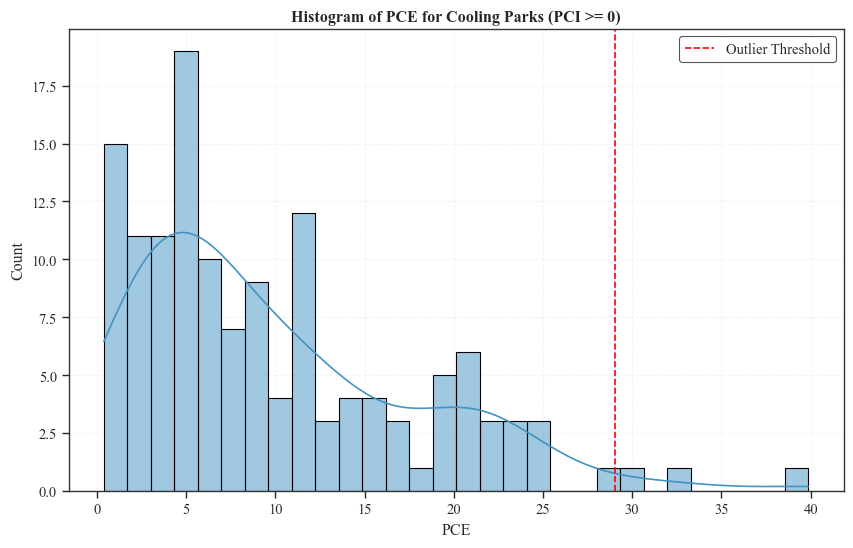

In [38]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=parks_gdf_cooling['PCE'])
plt.title('Boxplot of PCE for Cooling Parks (PCI >= 0)')
plt.show()
plt.figure(figsize=(10, 6))
sns.histplot(parks_gdf_cooling['PCE'], bins=30, kde=True)
plt.title('Histogram of PCE for Cooling Parks (PCI >= 0)')
plt.axvline(29.02, color='red', linestyle='--', label='Outlier Threshold')
plt.legend()
plt.show()

In [39]:
no_outliers_pce = parks_gdf_cooling[parks_gdf_cooling['PCE'] <= 29.02]['PCE']
print(f"Mean PCE without outliers: {no_outliers_pce.mean().round(2)}")
print(f"Median PCE: {parks_gdf_cooling['PCE'].median().round(2)}")

Mean PCE without outliers: 9.3
Median PCE: 7.59


## 4. Factors Assessment

In [64]:
parks_gdf.columns

Index(['osm_id', 'OBJECTID', 'FEATURE_ANAME', 'MUNICIPALITY', 'DISTRICT',
       'WALKING_TRACK', 'GREEN_AREAS', 'LAYERID', 'LAYERANAME', 'Validation',
       ...
       'lst_reduction_coef_building_proximity',
       'lst_reduction_tval_building_proximity',
       'lst_reduction_sig_building_proximity', 'lst_reduction_localR2_proxy',
       'geometry', 'size_category', 'PCI_quartile', 'PCA_quartile',
       'PCE_quartile', 'lst_reduction_quartile'],
      dtype='object', length=137)

In [85]:
# Factors and metrics (without .lower())
factors = ['log_area_m2', 'ndvi_mean', 'pisi_mean', 'LSI', 'building_density', 'building_proximity']
metrics = ['lst_reduction', 'PCI', 'PCA', 'PCE']
coef_cols = {metric: [f'{metric}_coef_{factor}' for factor in factors] for metric in metrics}
tval_cols = {metric: [f'{metric}_tval_{factor}' for factor in factors] for metric in metrics}
sig_cols = {metric: [f'{metric}_sig_{factor}' for factor in factors] for metric in metrics}
local_r2_cols = {metric: f'{metric}_localR2_proxy' for metric in metrics}

In [76]:
# Function to summarize MGWR influence
def summarize_mgwr_influence(df, metric, coef_cols, tval_cols, sig_cols, local_r2_col):
    summary = {}
    for factor, coef_col, tval_col, sig_col in zip(factors, coef_cols, tval_cols, sig_cols):
        mean_coef = df[coef_col].mean()
        mean_tval = df[tval_col].mean()
        sig_count = df[sig_col].sum()  # Count of 'true' significance
        summary[factor] = {'mean_coef': mean_coef, 'mean_tval': mean_tval, 'sig_count': sig_count}
    summary['local_r2'] = df[local_r2_col].mean()
    return summary

In [77]:
# Summarize influence for each metric
results = {}
for metric in metrics:
    results[metric] = summarize_mgwr_influence(parks_gdf, metric, coef_cols[metric], tval_cols[metric], sig_cols[metric], local_r2_cols[metric])

# Print summary
for metric, result in results.items():
    print(f"\n{metric.upper()} Influence Summary:")
    for factor, vals in result.items():
        if factor != 'local_r2':
            print(f"{factor}: Mean Coef = {vals['mean_coef']:.3f}, Mean t-value = {vals['mean_tval']:.2f}, "
                  f"Significant = {vals['sig_count']}/{len(parks_gdf)}")
    print(f"Local R² Proxy: {result['local_r2']:.3f}")


LST_REDUCTION Influence Summary:
log_area_m2: Mean Coef = 0.411, Mean t-value = 3.53, Significant = 88/194
ndvi_mean: Mean Coef = 0.372, Mean t-value = 5.29, Significant = 194/194
pisi_mean: Mean Coef = 0.203, Mean t-value = 1.81, Significant = 122/194
LSI: Mean Coef = -0.053, Mean t-value = 0.00, Significant = 0/194
building_density: Mean Coef = -0.117, Mean t-value = -0.07, Significant = 5/194
building_proximity: Mean Coef = -0.284, Mean t-value = -5.25, Significant = 194/194
Local R² Proxy: 0.676

PCI Influence Summary:
log_area_m2: Mean Coef = 0.416, Mean t-value = 3.15, Significant = 85/194
ndvi_mean: Mean Coef = 0.454, Mean t-value = 4.73, Significant = 194/194
pisi_mean: Mean Coef = 0.240, Mean t-value = 1.23, Significant = 90/194
LSI: Mean Coef = -0.018, Mean t-value = 0.00, Significant = 0/194
building_density: Mean Coef = -0.144, Mean t-value = -0.88, Significant = 59/194
building_proximity: Mean Coef = -0.343, Mean t-value = -4.74, Significant = 194/194
Local R² Proxy: 0.55

In [78]:
# Rank factors by influence (absolute mean coefficient for significant relationships)
def rank_influence(summary):
    significant = {f: v for f, v in summary.items() if f != 'local_r2' and v['sig_count'] > 0}
    return sorted(significant.items(), key=lambda x: abs(x[1]['mean_coef']), reverse=True)

for metric, result in results.items():
    print(f"\n{metric.upper()} Ranked Influence:")
    ranked = rank_influence(result)
    for factor, vals in ranked:
        print(f"{factor}: Mean Coef = {vals['mean_coef']:.3f}, Significant = {vals['sig_count']}/{len(parks_gdf)}")


LST_REDUCTION Ranked Influence:
log_area_m2: Mean Coef = 0.411, Significant = 88/194
ndvi_mean: Mean Coef = 0.372, Significant = 194/194
building_proximity: Mean Coef = -0.284, Significant = 194/194
pisi_mean: Mean Coef = 0.203, Significant = 122/194
building_density: Mean Coef = -0.117, Significant = 5/194

PCI Ranked Influence:
ndvi_mean: Mean Coef = 0.454, Significant = 194/194
log_area_m2: Mean Coef = 0.416, Significant = 85/194
building_proximity: Mean Coef = -0.343, Significant = 194/194
pisi_mean: Mean Coef = 0.240, Significant = 90/194
building_density: Mean Coef = -0.144, Significant = 59/194

PCA Ranked Influence:
log_area_m2: Mean Coef = 11190.935, Significant = 194/194
pisi_mean: Mean Coef = 4482.813, Significant = 153/194
LSI: Mean Coef = 2751.696, Significant = 177/194

PCE Ranked Influence:
log_area_m2: Mean Coef = -6.862, Significant = 194/194
pisi_mean: Mean Coef = 1.866, Significant = 194/194


Factors summary table

In [87]:


# Initialize dictionary to store summary statistics
table_data = []

# Function to summarize MGWR results for each factor-metric pair
def summarize_mgwr_factor(df, metric, factor):
    coef_col = f'{metric}_coef_{factor}'
    tval_col = f'{metric}_tval_{factor}'
    sig_col = f'{metric}_sig_{factor}'
    if coef_col in df.columns:  # Check if column exists
        mean_coef = df[coef_col].mean()
        mean_tval = df[tval_col].mean()
        sig_count = df[sig_col].sum()
        return {'Factor': factor, 'Metric': metric, 'Mean Coefficient': mean_coef, 'Mean t-value': mean_tval, 'Significant Parks': f'{sig_count}/{len(df)}'}
    return None

# Generate data for the table
for metric in metrics:
    for factor in factors:
        row = summarize_mgwr_factor(parks_gdf, metric, factor)
        if row:  # Only append if the row is valid
            table_data.append(row)

# Create DataFrame
table_df = pd.DataFrame(table_data)

# Format numeric columns
table_df['Mean Coefficient'] = table_df['Mean Coefficient'].round(3)
table_df['Mean t-value'] = table_df['Mean t-value'].round(2)

# Export to CSV
table_df.to_csv('Table1_MGWR_Summary.csv', index=False)

# Optional: Print table for verification
print(table_df.to_string(index=False))

            Factor        Metric  Mean Coefficient  Mean t-value Significant Parks
       log_area_m2 lst_reduction             0.411          3.53            88/194
         ndvi_mean lst_reduction             0.372          5.29           194/194
         pisi_mean lst_reduction             0.203          1.81           122/194
               LSI lst_reduction            -0.053          0.00             0/194
  building_density lst_reduction            -0.117         -0.07             5/194
building_proximity lst_reduction            -0.284         -5.25           194/194
       log_area_m2           PCI             0.416          3.15            85/194
         ndvi_mean           PCI             0.454          4.73           194/194
         pisi_mean           PCI             0.240          1.23            90/194
               LSI           PCI            -0.018          0.00             0/194
  building_density           PCI            -0.144         -0.88            59/194
buil

## 5. Standards/ Thresholds

In [113]:
# Function to get top quartile and summarize factors
def top_quartile_summary(df, metric):
    sorted_df = df.sort_values(metric, ascending=False)
    top_quartile = sorted_df.head(int(len(df) * 0.25))  # Top 25%
    summary = top_quartile[factors].describe().T[['mean', 'min', '25%', '50%', '75%', 'max']]
    summary['Metric'] = metric
    summary['Group'] = 'Top Quartile'
    overall_summary = df[factors].describe().T[['mean', 'min', '25%', '50%', '75%', 'max']]
    overall_summary['Metric'] = metric
    overall_summary['Group'] = 'Overall'
    return pd.concat([summary, overall_summary])

# Generate summaries
summaries = []
for metric in metrics:
    df = parks_gdf if metric == 'lst_reduction' else cooling_parks
    summaries.append(top_quartile_summary(df, metric))

In [115]:
# Combine and export to CSV
summary_df = pd.concat(summaries).reset_index().rename(columns={'index': 'Factor'})
summary_df.to_csv('top_quartile_factors_summary.csv', index=False)
print(summary_df)

                Factor       mean        min        25%        50%        75%  \
0          log_area_m2   9.521882   7.424076   8.542650   9.230849  10.396352   
1            ndvi_mean   0.172813   0.096112   0.149601   0.179284   0.193671   
2            pisi_mean  -0.205778  -0.339718  -0.237979  -0.213300  -0.175995   
3                  LSI   1.218750   1.060000   1.140000   1.180000   1.282500   
4     building_density  31.411503   1.359572  26.015734  32.407295  36.251114   
5   building_proximity  20.446813   1.620812  11.318084  16.272105  23.499285   
6          log_area_m2   8.737517   6.895126   7.982114   8.534237   9.209997   
7            ndvi_mean   0.149629   0.056360   0.126020   0.147426   0.172987   
8            pisi_mean  -0.173575  -0.376677  -0.220448  -0.177248  -0.127368   
9                  LSI   1.218093   1.060000   1.130000   1.170000   1.230000   
10    building_density  32.540256   1.359572  28.403743  33.158802  37.660383   
11  building_proximity  17.8

In [127]:

# Function to get top quartile and summarize factors with concise structure

# factors_summ = ['ndvi_mean', 'pisi_mean', 'LSI', 'building_density', 'building_proximity', 'area_m2']
factors_2 = ['log_area_m2', 'ndvi_mean', 'pisi_mean', 'LSI', 'building_density', 'building_proximity', 'area_m2']

def top_quartile_summary_concise(df, metric):
    sorted_df = df.sort_values(metric, ascending=False)
    top_quartile = sorted_df.head(int(len(df) * 0.25))  # Top 25%
    top_quartile_mean = top_quartile[factors_2].mean()
    overall_mean = df[factors_2].mean()
    
    # Create DataFrame with concise structure
    top_quartile_mean_df = pd.DataFrame({'Top quartile mean': top_quartile_mean})
    top_quartile_mean_df['Metric'] = metric
    top_quartile_mean_df['Factor'] = top_quartile_mean_df.index
    
    overall_mean_df = pd.DataFrame({'Overall mean': overall_mean})
    overall_mean_df['Metric'] = metric
    overall_mean_df['Factor'] = overall_mean_df.index
    
    # Merge and align
    summary_concise = pd.merge(top_quartile_mean_df[['Metric', 'Factor', 'Top quartile mean']], 
                              overall_mean_df[['Metric', 'Factor', 'Overall mean']], 
                              on=['Metric', 'Factor'])
    
    return summary_concise

# Generate summaries
summaries_concise = []
for metric in metrics:
    summaries_concise.append(top_quartile_summary_concise(cooling_parks, metric))

# Combine all summaries into a single DataFrame
summary_concise = pd.concat(summaries_concise, ignore_index=True)

# Export to CSV
summary_concise.to_csv('summary_concise_2.csv', index=False)

print(summary_concise)

           Metric              Factor  Top quartile mean  Overall mean
0   lst_reduction         log_area_m2           9.825992      8.855370
1   lst_reduction           ndvi_mean           0.175683      0.156953
2   lst_reduction           pisi_mean          -0.207163     -0.181809
3   lst_reduction                 LSI           1.222647      1.222774
4   lst_reduction    building_density          31.013943     32.628169
5   lst_reduction  building_proximity          22.324798     17.766363
6   lst_reduction             area_m2       45283.383235  17421.122628
7             PCI         log_area_m2           9.445287      8.855370
8             PCI           ndvi_mean           0.170779      0.156953
9             PCI           pisi_mean          -0.201970     -0.181809
10            PCI                 LSI           1.217941      1.222774
11            PCI    building_density          31.656351     32.628169
12            PCI  building_proximity          17.802049     17.766363
13    

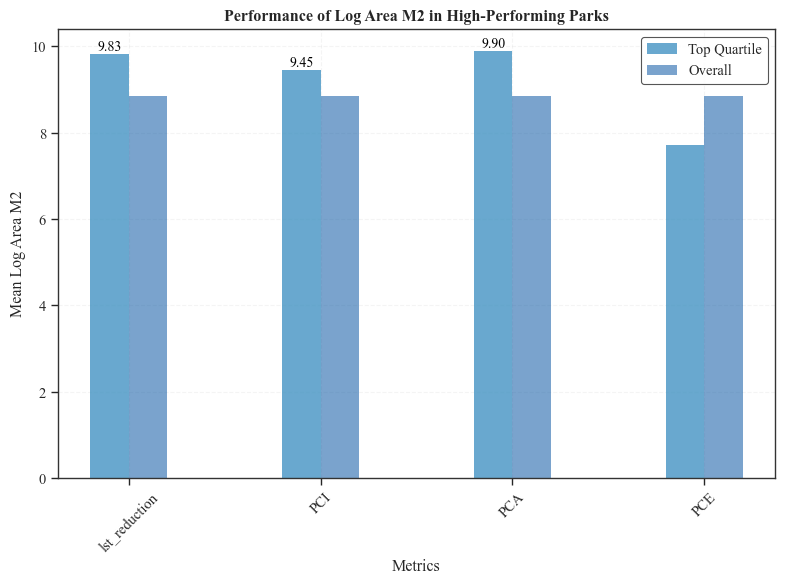

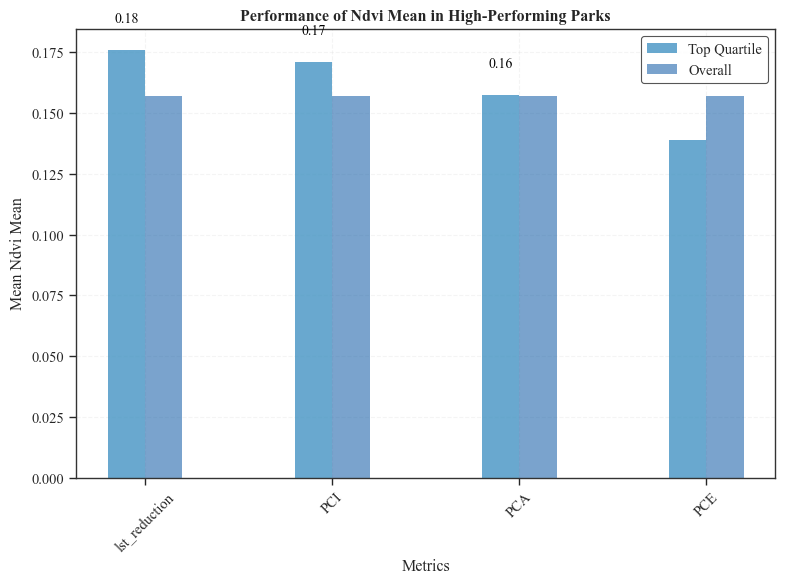

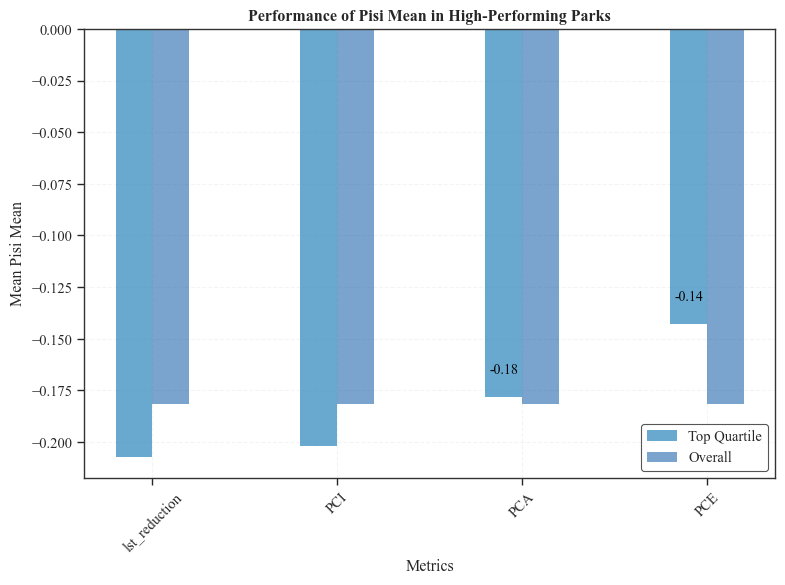

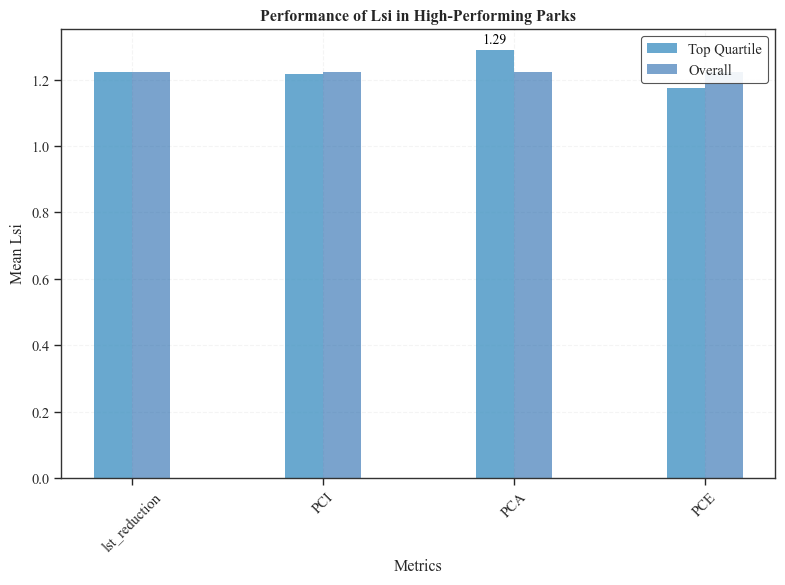

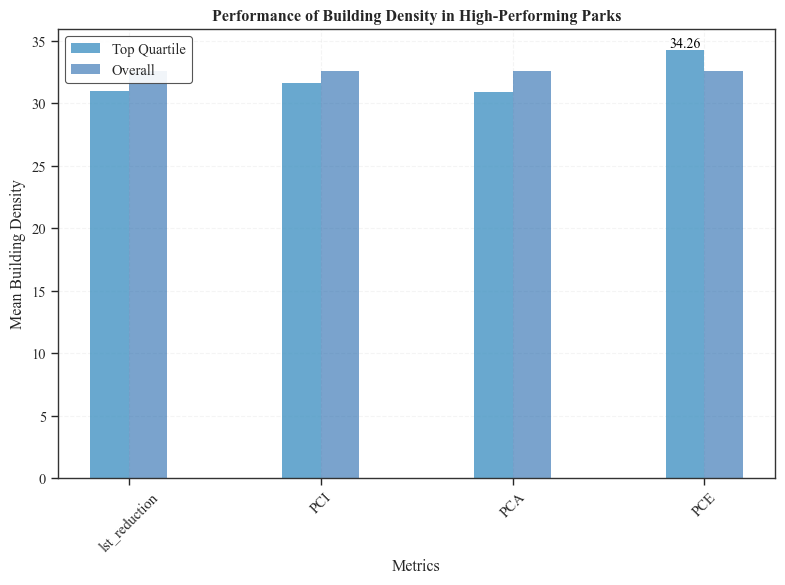

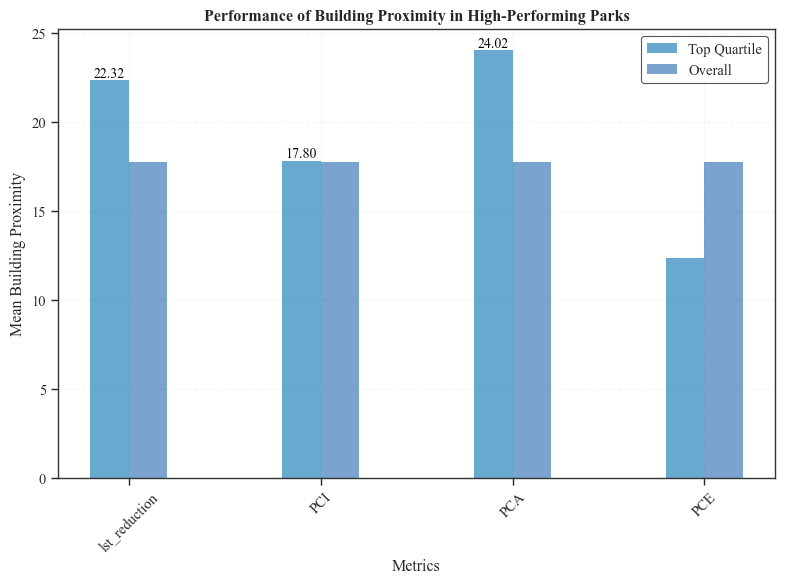

In [125]:
# Unique factors
factors = summary_concise['Factor'].unique()

# Generate a bar graph for each factor
for factor in factors:
    # Filter data for the current factor
    factor_data = summary_concise[summary_concise['Factor'] == factor]
    
    # Set up the figure
    plt.figure(figsize=(8, 6))
    
    # Bar plot
    x = np.arange(len(factor_data['Metric']))
    plt.bar(x - 0.1, factor_data['Top quartile mean'], width=0.2, label='Top Quartile', color=Colors[0], alpha=0.8)
    plt.bar(x + 0.1, factor_data['Overall mean'], width=0.2, label='Overall', color=Colors[4], alpha=0.6)
    
    # Annotate top quartile means for emphasis
    for i, val in enumerate(factor_data['Top quartile mean']):
        if val > factor_data['Overall mean'].iloc[i]:  # Highlight improvements
            plt.text(i - 0.1, val + 0.01, f'{val:.2f}', ha='center', va='bottom', color='black', fontsize=10)
    
    # Customize the plot
    plt.xlabel('Metrics')
    plt.ylabel(f'Mean {factor.replace("_", " ").title()}')
    plt.title(f'Performance of {factor.replace("_", " ").title()} in High-Performing Parks', fontweight='bold')
    plt.xticks(x, factor_data['Metric'], rotation=45)
    plt.legend(loc='best')
    plt.grid(True, linestyle='--', alpha=0.2)
    plt.tight_layout()
    
    # Save with custom styling
    plt.savefig(f'performance_{factor}.png', dpi=plt.rcParams['savefig.dpi'], 
                bbox_inches=plt.rcParams['savefig.bbox'], pad_inches=plt.rcParams['savefig.pad_inches'])
    plt.show()

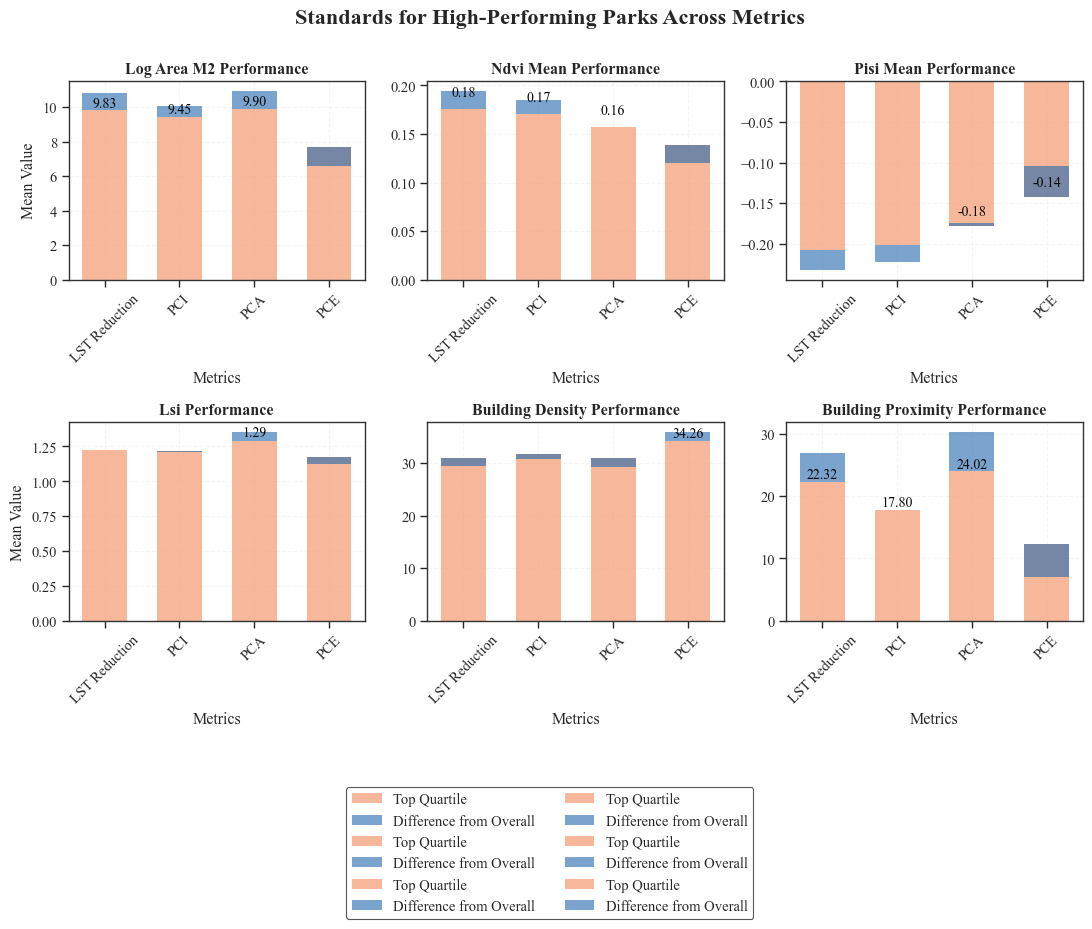

In [126]:

# Unique factors and metrics with label adjustment
factors = summary_concise['Factor'].unique()
metrics = summary_concise['Metric'].unique()
metrics_labels = {'lst_reduction': 'LST Reduction', 'PCI': 'PCI', 'PCA': 'PCA', 'PCE': 'PCE'}

# Create subplots (2 rows, 3 columns for 6 factors)
fig, axes = plt.subplots(2, 3, figsize=plt.rcParams['figure.figsize'], sharey=False)

# Flatten axes array for easy iteration
axes = axes.flatten()

# Generate stacked bar plot for each factor
for idx, factor in enumerate(factors):
    ax = axes[idx]
    factor_data = summary_concise[summary_concise['Factor'] == factor]
    
    # Prepare data for stacking: top quartile mean and difference from overall mean
    top_quartile_means = factor_data['Top quartile mean']
    overall_means = factor_data['Overall mean']
    differences = top_quartile_means - overall_means
    stacked_values = [top_quartile_means, differences]
    
    # Plot stacked bars
    x = np.arange(len(metrics))
    ax.bar(x, top_quartile_means, width=0.6, label='Top Quartile', color=Colors[1], alpha=0.8)
    ax.bar(x, differences, width=0.6, bottom=top_quartile_means, label='Difference from Overall', color=Colors[4], alpha=0.6)
    
    # Customize the plot
    ax.set_title(f'{factor.replace("_", " ").title()} Performance', fontweight='bold')
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Mean Value' if idx % 3 == 0 else '')  # Y-label only on first column
    ax.set_xticks(x)
    ax.set_xticklabels([metrics_labels[m] for m in factor_data['Metric']], rotation=45)
    ax.grid(True, linestyle='--', alpha=0.2)
    
    # Annotate top quartile means
    for i, val in enumerate(top_quartile_means):
        if differences.iloc[i] > 0:  # Highlight positive improvements
            ax.text(i, val + 0.01, f'{val:.2f}', ha='center', va='bottom', color='black', fontsize=10)

# Adjust layout and add legend
plt.tight_layout()
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2, frameon=True, framealpha=0.9, edgecolor='#444444')
fig.suptitle('Standards for High-Performing Parks Across Metrics', fontsize=16, fontweight='bold', y=1.05)

# Save with custom styling
plt.savefig('high_performing_parks_stacked_subplots.png', dpi=plt.rcParams['savefig.dpi'], 
            bbox_inches=plt.rcParams['savefig.bbox'], pad_inches=plt.rcParams['savefig.pad_inches'])
plt.show()

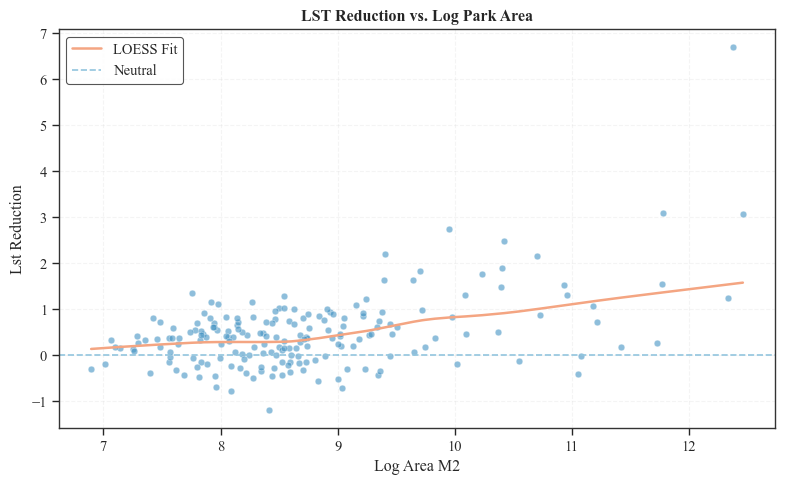

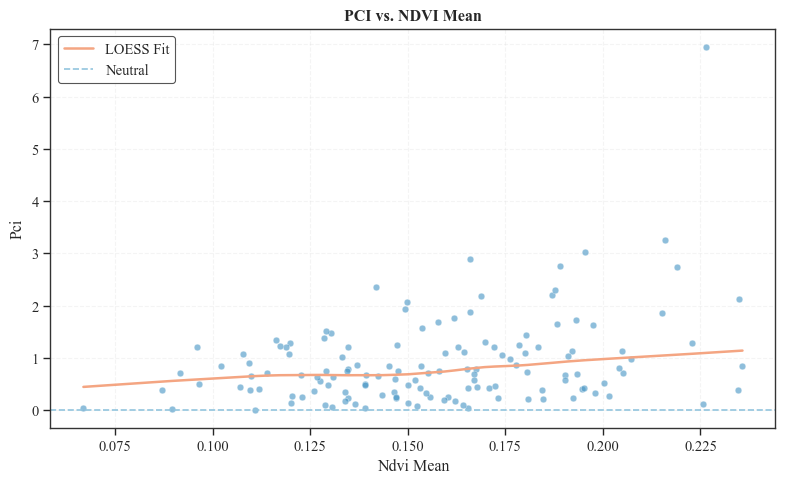

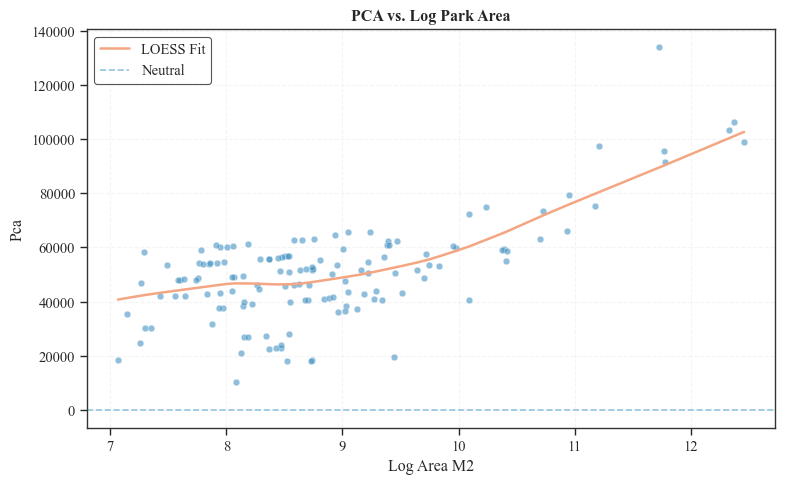

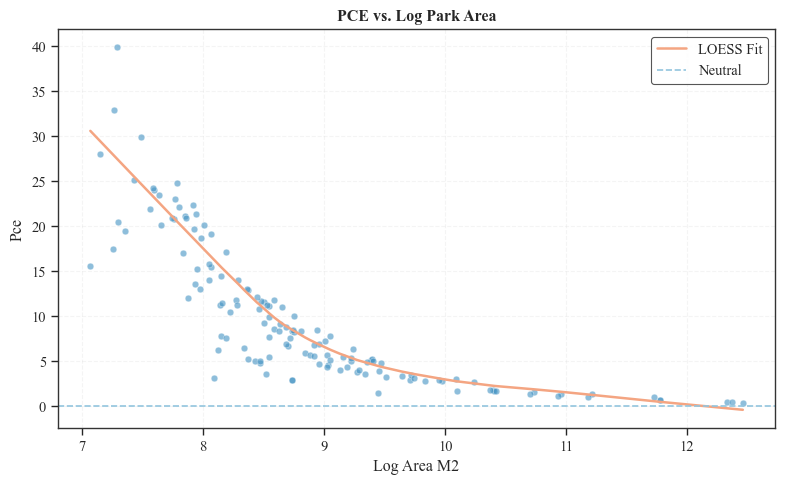

In [100]:
# Function to plot non-linear relationships
def plot_nonlinear(df, x, y, title):
    plt.figure(figsize=(8, 5))  # Adjusted for single plot
    sns.scatterplot(data=df, x=x, y=y, alpha=0.6, color=Colors[0])
    sns.regplot(data=df, x=x, y=y, lowess=True, scatter=False, color=Colors[1], label='LOESS Fit')
    plt.axhline(0, color=Colors[2], linestyle='--', label='Neutral')
    plt.title(title)
    plt.xlabel(x.replace('_', ' ').title())
    plt.ylabel(y.replace('_', ' ').title())
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'{y}_vs_{x}_nonlinear.png', dpi=plt.rcParams['savefig.dpi'], 
                bbox_inches=plt.rcParams['savefig.bbox'], pad_inches=plt.rcParams['savefig.pad_inches'])
    plt.show()

plot_nonlinear(parks_gdf, 'log_area_m2', 'lst_reduction', 'LST Reduction vs. Log Park Area')
plot_nonlinear(cooling_parks, 'ndvi_mean', 'PCI', 'PCI vs. NDVI Mean')
plot_nonlinear(cooling_parks, 'log_area_m2', 'PCA', 'PCA vs. Log Park Area')
plot_nonlinear(cooling_parks, 'log_area_m2', 'PCE', 'PCE vs. Log Park Area')

In [105]:
# Segmented regression function
def segmented_regression(x, y, break_point):
    x1 = x[x <= break_point]
    y1 = y[x <= break_point]
    x2 = x[x > break_point]
    y2 = y[x > break_point]
    
    if len(x1) < 2 or len(x2) < 2:
        return np.inf, None, None  # Invalid if fewer than 2 points in segment
    
    X1 = sm.add_constant(x1)
    model1 = sm.OLS(y1, X1).fit()
    X2 = sm.add_constant(x2)
    model2 = sm.OLS(y2, X2).fit()
    
    rss = model1.ssr + model2.ssr
    return rss, model1, model2

# Find breakpoint by minimizing RSS
def find_threshold(df, x, y):
    x_vals = df[x].values
    y_vals = df[y].values
    indices = np.argsort(x_vals)
    x_sorted = x_vals[indices]
    y_sorted = y_vals[indices]
    
    possible_breaks = x_sorted[1:-1]  # Avoid extremes
    rss_values = []
    for bp in possible_breaks:
        rss, _, _ = segmented_regression(x_sorted, y_sorted, bp)
        rss_values.append(rss)
    
    valid_indices = [i for i, rss in enumerate(rss_values) if np.isfinite(rss)]
    if not valid_indices:
        return np.nan
    
    min_rss_index = valid_indices[np.argmin([rss_values[i] for i in valid_indices])]
    optimal_bp = possible_breaks[min_rss_index]
    print(f"Estimated threshold for {x} on {y}: {optimal_bp:.2f}")
    return optimal_bp

In [107]:
# Find thresholds
find_threshold(parks_gdf, 'log_area_m2', 'lst_reduction')
find_threshold(cooling_parks, 'ndvi_mean', 'PCI')
find_threshold(cooling_parks, 'log_area_m2', 'PCA')
find_threshold(cooling_parks, 'log_area_m2', 'PCE')

Estimated threshold for log_area_m2 on lst_reduction: 12.33
Estimated threshold for ndvi_mean on PCI: 0.23
Estimated threshold for log_area_m2 on PCA: 8.06
Estimated threshold for log_area_m2 on PCE: 8.06


np.float64(8.06183380983423)

Analysis related graphs

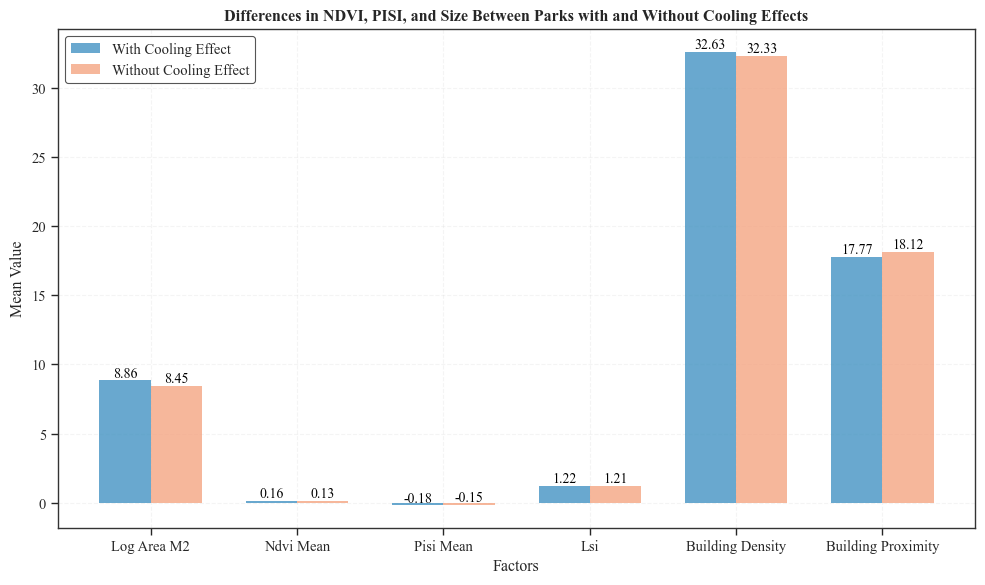

In [128]:

# Categorize parks by cooling effect (using PCI as proxy)
parks_gdf['Cooling_Effect'] = parks_gdf['PCI'] >= 0
cooling_parks = parks_gdf[parks_gdf['Cooling_Effect']]
non_cooling_parks = parks_gdf[~parks_gdf['Cooling_Effect']]

# Calculate means for each factor by cooling effect
cooling_means = cooling_parks[factors].mean()
non_cooling_means = non_cooling_parks[factors].mean()

# Set up the figure
fig, ax = plt.subplots(figsize=(10, 6))

# Bar positions
x = np.arange(len(factors))
width = 0.35

# Plot bars
bars1 = ax.bar(x - width/2, cooling_means, width, label='With Cooling Effect', color=Colors[0], alpha=0.8)
bars2 = ax.bar(x + width/2, non_cooling_means, width, label='Without Cooling Effect', color=Colors[1], alpha=0.8)

# Add value labels on top of bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01, f'{height:.2f}', 
                ha='center', va='bottom', fontsize=10, color='black')

# Customize the plot
ax.set_xlabel('Factors')
ax.set_ylabel('Mean Value')
ax.set_title('Differences in NDVI, PISI, and Size Between Parks with and Without Cooling Effects', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f.replace('_', ' ').title() for f in factors])
ax.legend(loc='best')
ax.grid(True, linestyle='--', alpha=0.2)

# Adjust layout and save
plt.tight_layout()
# plt.savefig('cooling_effect_comparison.png', dpi=plt.rcParams['savefig.dpi'], 
#             bbox_inches=plt.rcParams['savefig.bbox'], pad_inches=plt.rcParams['savefig.pad_inches'])
plt.show()

In [134]:

heating_parks = parks_gdf[parks_gdf['PCI'] < 0]
# Calculate means and perform t-test
ndvi_cooling_mean = cooling_parks['ndvi_mean'].mean()
ndvi_heating_mean = heating_parks['ndvi_mean'].mean()
ndvi_cooling_std = cooling_parks['ndvi_mean'].std()
ndvi_heating_std = heating_parks['ndvi_mean'].std()
n_cooling = len(cooling_parks)
n_heating = len(heating_parks)

t_stat, p_value = stats.ttest_ind(cooling_parks['ndvi_mean'].dropna(), heating_parks['ndvi_mean'], equal_var=False)
print(f"NDVI Mean (Cooling): {ndvi_cooling_mean:.2f}, Std: {ndvi_cooling_std:.2f}, n: {n_cooling}")
print(f"NDVI Mean (Heating): {ndvi_heating_mean:.2f}, Std: {ndvi_heating_std:.2f}, n: {n_heating}")
print(f"t-statistic: {t_stat:.2f}, p-value: {p_value:.4f}")

# Significant if p < 0.05
if p_value < 0.05:
    print("The difference in NDVI means between cooling and heating parks is statistically significant.")
else:
    print("The difference in NDVI means is not statistically significant.")

NDVI Mean (Cooling): 0.16, Std: 0.03, n: 137
NDVI Mean (Heating): 0.13, Std: 0.03, n: 57
t-statistic: 4.98, p-value: 0.0000
The difference in NDVI means between cooling and heating parks is statistically significant.


In [137]:
# cooling_parks = parks_gdf[parks_gdf['PCI'] > 0]

cooling_parks['area_m2'].describe()


count       137.000000
mean      17421.122628
std       39798.466018
min        1170.510000
25%        3170.100000
50%        5605.300000
75%       11357.570000
max      258129.690000
Name: area_m2, dtype: float64

In [138]:
cooling_parks['PCA'].describe()


count       137.000000
mean      50721.786487
std       18376.185374
min       10274.115459
25%       40858.136911
50%       50960.828954
75%       59242.301696
max      133933.704782
Name: PCA, dtype: float64

In [139]:
cooling_parks['PCI'].describe()


count    137.000000
mean       0.910336
std        0.859750
min        0.006695
25%        0.376128
50%        0.710206
75%        1.208088
max        6.950153
Name: PCI, dtype: float64